<a href="https://colab.research.google.com/github/ChrisNassif/Yolo_Demo/blob/main/RealTimeFacialDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# install requirements
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.8/871.8 kB 32.7 MB/s eta 0:00:00


In [2]:
# download yolo models from the internet
!mkdir weights
!wget -O weights/yolov10b.pt -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -O weights/yolov10x.pt -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -O weights/yolov9m.pt -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-m-converted.pt
!wget -O weights/yolov9c.pt -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c-converted.pt
!wget -O yolov10_source -q https://github.com/THU-MIG/yolov10

# download roboflow dataset from the internet (https://universe.roboflow.com/objectdetection-dxeuw/face-detection-z1x9s/dataset/1)
!curl -L "https://app.roboflow.com/ds/LiMNdXI626?key=uP89r7g713" > roboflow.zip
!unzip roboflow.zip -d dataset
!rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset/train/images/download-2-_jpeg_jpg.rf.bfae7a634e4a0828c5673e3e71dbc458.jpg  
 extracting: dataset/train/images/face-detection_mp4-13_jpg.rf.60af1e6b8166eb34530800d39b570816.jpg  
 extracting: dataset/train/images/face-detection_mp4-13_jpg.rf.73ce82334cc411886343dea08c8235a5.jpg  
 extracting: dataset/train/images/face-detection_mp4-13_jpg.rf.7967699b45aacbc0757ee3cb7569ec32.jpg  
 extracting: dataset/train/images/face-detection_mp4-13_jpg.rf.ca2b1beb0f0bcc069c8adac7f414fc0b.jpg  
 extracting: dataset/train/images/face-detection_mp4-15_jpg.rf.05faee67c35376dd37b060fa76e7bf69.jpg  
 extracting: dataset/train/images/face-detection_mp4-15_jpg.rf.7a46e1726e5e4fb9be1c5cfee3acecf0.jpg  
 extracting: dataset/train/images/face-detection_mp4-15_jpg.rf.a9940b1014e8d7c67be1757d4587a6b1.jpg  
 extracting: dataset/train/images/face-detection_mp4-15_jpg.rf.c47aaf09c9d8a0565a69ccc1c26f9de1.jpg  
 extracting: dataset/train/images/fa

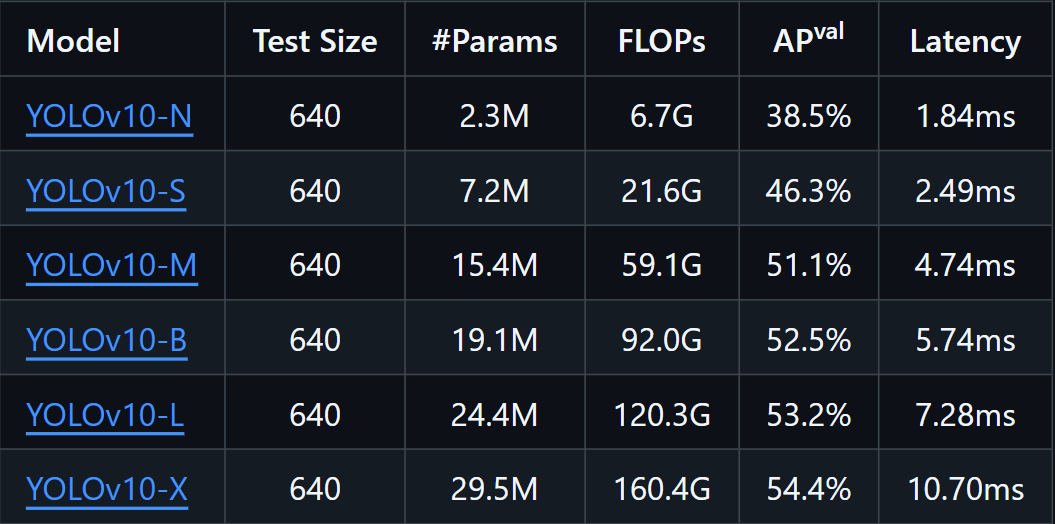

In [3]:
# THIS IS ALL TO ACCESS THE WEBCAM, YOU CAN LITERALLY COPY PASTE THIS CODE FROM THE FOLLOWING GOOGLE COLAB LINK (Thats what I did):
# https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=1nkSnkbkk4cC


# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getTracks().forEach(track => track.stop());
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 640);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 640; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data


def perform_real_time_object_detection(get_bounding_boxes_from_image_function):
    # start streaming video from webcam
    video_stream()
    # label for video
    label_html = 'Capturing...'
    # initialze bounding box to empty
    bbox = ''
    count = 0
    while True:
        js_reply = video_frame(label_html, bbox)
        if not js_reply:
            break

        # convert JS response to OpenCV Image
        img = js_to_image(js_reply["img"])

        # create transparent overlay for bounding box
        bbox_array = np.zeros([640,640,4], dtype=np.uint8)

        # get face region coordinates
        faces = get_bounding_boxes_from_image_function(img)
        # get face bounding box for overlay
        for (x,y,w,h) in faces:
            bbox_array = cv2.rectangle(bbox_array,(x-int(w/2), y-int(h/2)),(x+int(w/2),y+int(h/2)),(255,0,0),2)

        bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
        # convert overlay of bbox into bytes
        bbox_bytes = bbox_to_bytes(bbox_array)
        # update bbox so next frame gets new overlay
        bbox = bbox_bytes

**Yolov2 Architecture**
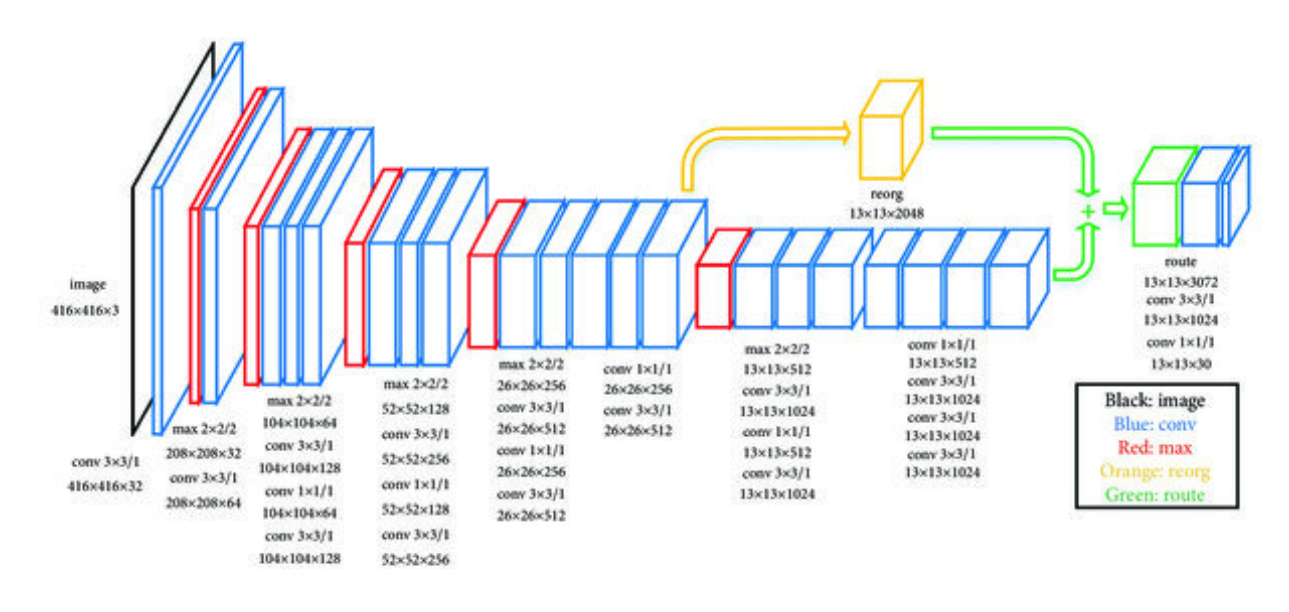

**Making Predictions In A Grid**

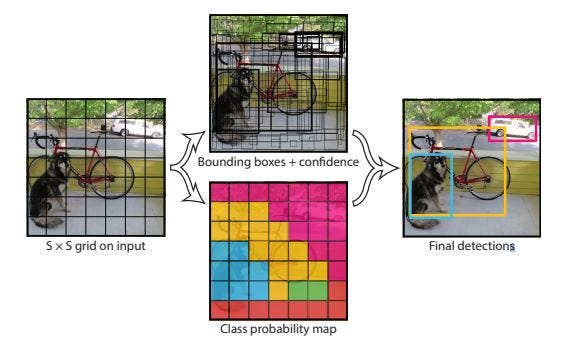

**Non-Max Suppression and Intersection over Union**

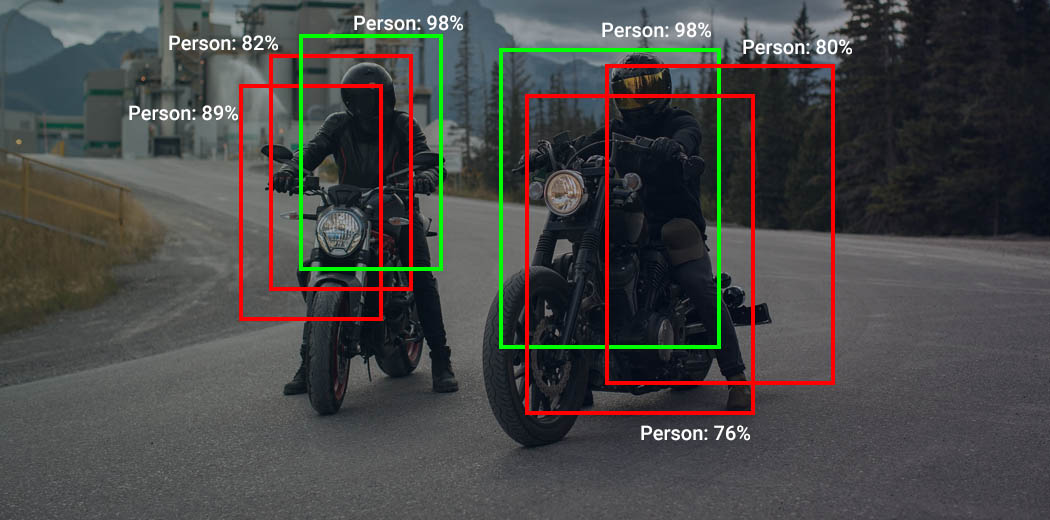

In [6]:
# Lets train a machine learning model to detect faces from finetuning a YOLO model!
from ultralytics import YOLO
import numpy as np

# Load the model through ultralytics
model = YOLO('weights/yolov10b.pt')

model.train(
    data="/content/dataset/data.yaml",
    batch=16,
    epochs=10,
    freeze=22,
    imgsz=640,
    lr0=0.005,
    optimizer="AdamW"
)

Ultralytics YOLOv8.2.90 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=weights/yolov10b.pt, data=/content/dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=22, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

100%|██████████| 755k/755k [00:00<00:00, 36.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  4   1444864  ultralytics.nn.modules.block.C2f             [256, 256, 4, True]           
  5                  -1  1    137728  ultralytics.nn.modules.block.SCDown          [256, 512, 3, 2]              
  6                  -1  4   5773312  ultralytics.nn.modules.block.C2f             [512, 512, 4, True]           
  7                  -1  1    268800  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 171MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 2568 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2568/2568 [00:01<00:00, 1939.81it/s]

train: WARNING ⚠️ /content/dataset/train/images/101_jpg.rf.2a4c434eea2a34cab39599215ffd3f03.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/101_jpg.rf.cab1579e38be29db15467970d94f4855.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/104_jpg.rf.523238dab968ae3da0c7307a4a5751ad.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/104_jpg.rf.b86fbaa59fb7ed415147e1ea9b4a1946.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/104_jpg.rf.eba74b362c19f650f76ffa153ea73a19.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/107_jpg.rf.40366e21c7a1ddbe63a5f392afb01fb5.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/107_jpg.rf.a366e93d6f731032b20b013e912c9cc4.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/dataset/train/images/107_jpg.rf.a9c878ec57243438fdbcf356bb25a620.jpg: 2 duplicate labels removed
train: W

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/dataset/valid/labels... 553 images, 0 backgrounds, 0 corrupt: 100%|██████████| 553/553 [00:00<00:00, 663.63it/s]


val: New cache created: /content/dataset/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.937) with parameter groups 135 weight(decay=0.0), 148 weight(decay=0.0005), 147 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.48G      2.876      3.453      4.067          8        640: 100%|██████████| 161/161 [01:18<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:12<00:00,  1.46it/s]

                   all        553        572      0.653      0.718      0.733      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.02G       2.56      2.373      3.646         12        640: 100%|██████████| 161/161 [01:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]

                   all        553        572      0.545       0.54      0.526      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.01G      2.362       2.09      3.398          9        640: 100%|██████████| 161/161 [01:07<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:11<00:00,  1.51it/s]

                   all        553        572      0.741      0.726      0.796       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.01G      2.204      1.831      3.174          9        640: 100%|██████████| 161/161 [01:09<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]

                   all        553        572      0.707      0.788      0.825      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.24G      2.041      1.716      2.964          8        640: 100%|██████████| 161/161 [01:08<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.67it/s]

                   all        553        572      0.729      0.774      0.817      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.33G      1.951      1.552      2.816         29        640: 100%|██████████| 161/161 [01:10<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]

                   all        553        572      0.769      0.785      0.848      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.37G      1.881      1.429      2.754         15        640: 100%|██████████| 161/161 [01:08<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.64it/s]

                   all        553        572      0.793      0.785       0.87      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.22G      1.798      1.369      2.642          8        640: 100%|██████████| 161/161 [01:10<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]

                   all        553        572      0.828      0.809      0.907      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.37G      1.695      1.271      2.559          8        640: 100%|██████████| 161/161 [01:07<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]

                   all        553        572      0.878      0.811      0.924      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       3.2G      1.628      1.203      2.484          9        640: 100%|██████████| 161/161 [01:10<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:10<00:00,  1.65it/s]

                   all        553        572      0.876      0.846      0.942      0.781



10 epochs completed in 0.242 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 41.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 41.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.90 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10b summary (fused): 383 layers, 20,412,694 parameters, 0 gradients, 97.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]


                   all        553        572      0.877      0.846      0.942      0.781
Speed: 0.3ms preprocess, 14.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d105c3a60e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [11]:
# Lets try to use a vision language model to detect heads without finetuning!
from ultralytics import YOLOWorld

# model = YOLOWorld("yolov8x-worldv2.pt")
# model.set_classes(["head", "face", "eyes", "person"])

def get_image_bounding_box(image: np.ndarray):
    bounding_boxes = []
    results = model.predict(image, conf=0.3, imgsz=640)
    for result in results:
        for box in result.boxes:
            print(box.xywh[0].to(int).tolist())
            bounding_boxes.append(box.xywh[0].to(int).tolist())

    return bounding_boxes

perform_real_time_object_detection(get_image_bounding_box)

<IPython.core.display.Javascript object>


0: 640x640 1 Face, 46.2ms
Speed: 2.7ms preprocess, 46.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
[321, 315, 637, 630]

0: 640x640 1 Face, 46.1ms
Speed: 2.3ms preprocess, 46.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
[320, 317, 639, 633]

0: 640x640 (no detections), 46.3ms
Speed: 2.3ms preprocess, 46.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Face, 46.3ms
Speed: 3.2ms preprocess, 46.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
[320, 319, 639, 636]

0: 640x640 1 Face, 46.3ms
Speed: 2.4ms preprocess, 46.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
[320, 318, 638, 635]

0: 640x640 1 Face, 46.4ms
Speed: 3.0ms preprocess, 46.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
[320, 318, 639, 636]

0: 640x640 1 Face, 46.3ms
Speed: 2.4ms preprocess, 46.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
[320, 319, 639, 63

KeyboardInterrupt: 

In [ ]:
# Lets try to make a yolo model from scratch!
# import torch
# import torch.utils
# import torch.utils.data

# from PIL import Image
# import glob
# import numpy as np

# # Step 1 Make a Pytorch Dataset and DataLoader object
# class Faces_Dataset(torch.utils.data.Dataset):
#     def __init__(self, dataset_path):
#         self.images = []
#         self.labels = []

#         for filename in glob.glob(f"{dataset_path}/train/images/*.jpg"):
#             pil_image: Image = Image.open(filename)
#             self.images.append(pil_image)

#         for filename in glob.glob(f"{dataset_path}/train/labels/*.txt"):
#             with open(filename) as label_file:
#                 for line in label_file:
#                     label = line.split(" ") # class, bounding box x, y, width, height
#                     numpy_label = np.array(label, dtype=float)
#                     self.labels.append(numpy_label)



#     def __getitem__(self, index):
#         return (self.images[index], self.labels[index])

#     def __len__(self):
#         return len(self.images)


# faces_dataset = Faces_Dataset("face_detection_dataset")
# faces_dataloader = torch.utils.data.DataLoader(
#     faces_dataset,
#     batch_size=10,
#     shuffle=True
# )



# class Face_Detector(torch.nn.Module):
#     def __init__(self):
#         super(Face_Detector, self).__init__()

#         # TODO: check image dimensions
#         self.conv_layer1 = torch.nn.Conv2d(in_channels=3, out_channels=128, kernel_size=7, stride=2, padding=3)
#         self.conv_layer2 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2)
#         self.conv_layer3 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
#         self.conv_layer4 = torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.conv_layer5 = torch.nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1)

#         # TODO assuming dimensions are the grid size * number of


#     def forward(self, input):
#         input = self.conv_layer1(input)
#         input = self.conv_layer2(input)
#         input = self.conv_layer3(input)
#         input = self.conv_layer4(input)
#         input = self.conv_layer5(input)



#     def perform_non_max_suppression(self, bounding_boxes):
#         pass

# model = Face_Detector()

# bounding_box_loss_function = torch.nn.MSELoss()
# classification_loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
# for epoch in range(10):
#     for images_batch, labels_batch in faces_dataloader:
#         model_output = model(labels_batch)